(c) 2023 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
# Load project package
@load_pkg BayesFitness

import Revise
import Suppressor
# Import project package
import BayesFitness
# Import library to list files
import Glob

# Import package to handle DataFrames
import DataFrames as DF
import CSV
import XLSX

# Import basic statistical functions
import StatsBase
import Random
import Distributions

# Import basic math
import LinearAlgebra

# Functionality for constructing arrays with identical elements efficiently.
import FillArrays

# Import libraries relevant for MCMC
import Turing
import MCMCChains

# Load CairoMakie for plotting
using CairoMakie
import ColorSchemes
import Makie
# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
BayesFitness.viz.pboc_makie!()

# Bayesian inference of the mean fitness

In this notebook, we perform Bayesian inference on the mean fitness of a yeast
population based on the frequency change of barcoded neutral strains.

## The fitness model

Empirically, we have seen that the barcode trajectories follow an exponential
function of the form
$$
f_{t+1}^{(m)} = f_{t}^{(m)} \mathrm{e}^{(s^{(m)} - \bar{s}_t)T},
$$
where $f_{t}^{(m)}$ is the frequency of barcode $m$ at time $t$, $s^{(m)}$ is
the relative fitness with respect to the ancestral strain, $\bar{s}_t$ is the 
mean fitness of the culture at time $t$ and $T$ is the time pass between time 
$t$ and $t+1$. It is important to notice that the frequencies $f_{t}^{(m)}$ 
are not the allele frequencies in the population (most of the culture is not
sequenced since it is not barcoded), but rather the inferred frequencies from
the total number of reads.

Our ultimate objective is to infer the relative fitness $s^{(m)}$ for each of
the mutants. But, to do so, we must first infer the population mean fitness
$\bar{s}_t$. For this, we use a set of barcoded strains that have the same
fitness as the ancestral strain--which by definition has $s^{(m)} = 0$. Here, we
will use these barcoded strains to determine the value of the population mean
fitness in a principled way using Bayesian inference.

## Non-Bayesian data normalization

Before implementing the full Bayesian model, let's explore the data. We will
take a look at what the frequency changes look like with and without the
normalization by the neutrals.

First, let's load the data.

In [2]:
# Load data
df = CSV.read("$(git_root())/data/big_batch/tidy_counts.csv", DF.DataFrame)

first(df, 5)

Row,BCID_x,bc_merged,barcode,barcode_lowcomplexity,barcode_highcomplexity,BCID_y,barcode_fasta,source_publication,cloneID,cloneID_new,evolution_condition,ancestor,class,ploidy,ploidy_new,gene,type,additional_muts,1D_Fitness_Li2019,1D_Error_Li2019,2D_Fitness_Li2019,2D_Error_Li2019,3D_Fitness_Li2019,3D_Error_Li2019,5D_Fitness_Li2019,5D_Error_Li2019,FerPerHour_Li2019,ResPerHour_Li2019,StaPerHour_Li2019,name,count,rep,timepoint,time,batch,hub,perturbation,neutral
,Int64,String,String,String31,String,Int64,String,String15,String31,String?,String7,String15,String31,String15,String15,String31,String?,String?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,String,Int64,String3,String3,Int64,String7,String7,String15,Bool
1,0,GAGTGAAACATGAATGGTATTCATCATGATCAATCTACAAAAATATTTAATG,TGATCAATCTACAAAAATATTTAATG_GAGTGAAACATGAATGGTATTCATCA,TGATCAATCTACAAAAATATTTAATG,GAGTGAAACATGAATGGTATTCATCA,0,GAGTGAAACATGAATGGTATTCATCATGATCAATCTACAAAAATATTTAATG,This_study,missing,EVO2D_IRA1_MIS_rearray_Plate1-A1,Evo2D,IRA1_MIS,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,53,R1,T0,0,Batch1,1Day,28,false
2,1,ACTCTAACGTGTAACTAATTTTGAGTCCGCCAATCCCGAACCCCGTTTCGCC,CCGCCAATCCCGAACCCCGTTTCGCC_ACTCTAACGTGTAACTAATTTTGAGT,CCGCCAATCCCGAACCCCGTTTCGCC,ACTCTAACGTGTAACTAATTTTGAGT,1,ACTCTAACGTGTAACTAATTTTGAGTCCGCCAATCCCGAACCCCGTTTCGCC,Aggeli2020,gpb2_evo1_plate9_H8,gpb2_evo1_plate9_H8,Evo2D,GPB2,adaptive_haploids,Haploid,Haploid,missing,Other,DOP1-NON_SYNONYMOUS_CODING; SMD2-NON_SYNONYMOUS_CODING; YDL180W-DOWNSTREAM; LAS21-UPSTREAM,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,1213,R1,T0,0,Batch1,1Day,28,false
3,2,ATGGGAACACGGAATGATCTTTTATTGACAGAAAAGCCAAATGGATTTACCG,GACAGAAAAGCCAAATGGATTTACCG_ATGGGAACACGGAATGATCTTTTATT,GACAGAAAAGCCAAATGGATTTACCG,ATGGGAACACGGAATGATCTTTTATT,2,ATGGGAACACGGAATGATCTTTTATTGACAGAAAAGCCAAATGGATTTACCG,This_study,missing,EVO3D_TCG_rearray_Plate1-A4,Evo3D,CYR1,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,17,R1,T0,0,Batch1,1Day,28,false
4,3,TACTAAATAAGTAAGGGAATTCTGTTCCAACAAAACACAAATCTGTTGTGTA,CCAACAAAACACAAATCTGTTGTGTA_TACTAAATAAGTAAGGGAATTCTGTT,CCAACAAAACACAAATCTGTTGTGTA,TACTAAATAAGTAAGGGAATTCTGTT,3,TACTAAATAAGTAAGGGAATTCTGTTCCAACAAAACACAAATCTGTTGTGTA,This_study,missing,EVO2D_IRA1_NON_rearray_Plate1-A1,Evo2D,IRA1_NON,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,19,R1,T0,0,Batch1,1Day,28,false
5,4,ATGACAAACTTTAAATAATTTAATTGTATCGAAACCCAAAGAGATTTAATCG,TATCGAAACCCAAAGAGATTTAATCG_ATGACAAACTTTAAATAATTTAATTG,TATCGAAACCCAAAGAGATTTAATCG,ATGACAAACTTTAAATAATTTAATTG,4,ATGACAAACTTTAAATAATTTAATTGTATCGAAACCCAAAGAGATTTAATCG,This_study,missing,EVO3D_IRA1_MIS_rearray_Plate1-C4,Evo3D,IRA1_MIS,missing,missing,haploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,23,R1,T0,0,Batch1,1Day,28,false


Let's plot some of the barcode trajectories. We will highlight the neutral
lineages with darker lines.

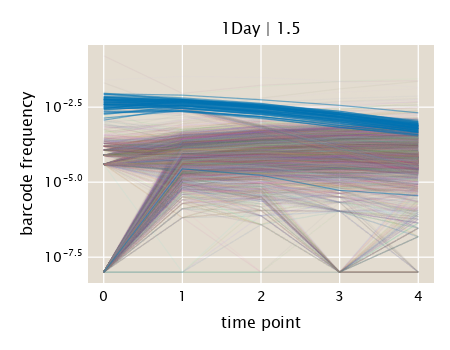

In [3]:
Random.seed!(42)

# Define information for data to extract
# Define batch
batch = "Batch2"
hub = "1Day"
perturbation = "1.5"
rep = "R1"

# Extract data. Note: The time T0 is common to all perturbations, thus, it must
# be extracted separately as a second condition.
data = df[
        (df.hub .== hub) .& 
        (df.batch .== batch) .&
        (df.perturbation .== perturbation) .&
        (df.rep .== rep)
    ,
:]

# Extract total counts per barcode
data_total = DF.combine(DF.groupby(data, :time), :count => sum)
# Extract total counts per barcode
data_total = DF.combine(DF.groupby(data, :time), :count => sum)
# Add total count column to dataframe
DF.leftjoin!(data, data_total; on=:time)
# Add frequency column
DF.insertcols!(data, :freq => data.count ./ data.count_sum)

# Initialize figure
fig = Figure(resolution=(450, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time point",
    ylabel="barcode frequency",
    yscale=log10,
    title="$(hub) | $(perturbation)"
)

# Define color palette
colors = ColorSchemes.glasbey_hv_n256

# group data by barcode
data_group = DF.groupby(data[.!data.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        bc.time, 
        bc.freq .+ 1E-8,
        color=(colors[StatsBase.sample(1:length(colors))], 0.05)
    )
end # for

# group neutral barcodes by barcode
data_group = DF.groupby(data[data.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        bc.time, 
        bc.count ./ data_total.count_sum .+ 1E-8,
        color=(ColorSchemes.seaborn_colorblind[1], 0.5)
    )
end # for

fig

these are the naive frequencies computed by simply normalizing the barcode
counts by the total number of counts. It is obvious that something strange
happened between time point `T0` and `T1`, where many barcodes drastically
increased in frequency. We wil deal with these anomalies later.

Now, let's plot the finite differences in the log frequencies vs time. In other
words, the $y$-axis will now represent $\log(f_{t+1}/f_{t})$.

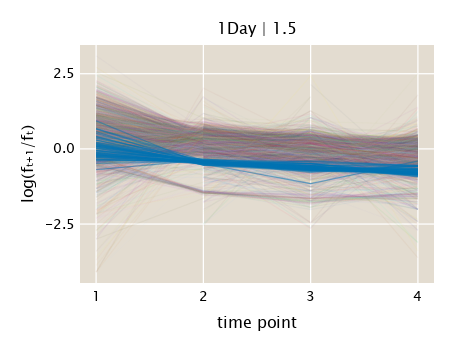

In [4]:
Random.seed!(42)

# Define information for data to extract
# Define batch
batch = "Batch2"
hub = "1Day"
perturbation = "1.5"
rep = "R1"

# Extract data. Note: The time T0 is common to all perturbations, thus, it must
# be extracted separately as a second condition.
data = df[
        (df.hub .== hub) .& 
        (df.batch .== batch) .&
        (df.perturbation .== perturbation) .&
        (df.rep .== rep)
    ,
:]

# Extract total counts per barcode
data_total = DF.combine(DF.groupby(data, :time), :count => sum)
# Extract total counts per barcode
data_total = DF.combine(DF.groupby(data, :time), :count => sum)
# Add total count column to dataframe
DF.leftjoin!(data, data_total; on=:time)
# Add frequency column
DF.insertcols!(data, :freq => data.count ./ data.count_sum)

# Initialize dataframe to save the log freq changes
data_log = DF.DataFrame()

# Group data by barcode
data_group = DF.groupby(data, :barcode)

# Loop through each group
for d in data_group
    # Compute log change
    DF.append!(
        data_log, 
        DF.DataFrame(
            :barcode .=> first(d.barcode),
            :time => d.time[2:end],
            :logf => diff(log.(d.freq)),
            :neutral .=> first(d.neutral)
        )
    )
end # for

# Initialize figure
fig = Figure(resolution=(450, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time point",
    ylabel="log(fₜ₊₁/fₜ)",
    title="$(hub) | $(perturbation)"
)

# Define color palette
colors = ColorSchemes.glasbey_hv_n256

# group data by barcode
data_group = DF.groupby(data_log[.!data_log.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        bc.logf,
        color=(colors[StatsBase.sample(1:length(colors))], 0.05)
    )
end # for

# group neutral barcodes by barcode
data_group = DF.groupby(data_log[data_log.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        bc.logf,
        color=(ColorSchemes.seaborn_colorblind[1], 0.5)
    )
end # for

fig

From this plot, we can see that since all neutrals lie below zero, the mean
fitness of the culture must be increasing, since, as shown above, for the
mutants we have
$$
\bar{s}_{t} = - \frac{1}{T} \log \left(\frac{f_{t+1}}{f_t} \right).
$$
Therefore, if the log ratio of the neutrals is negative, the mean fitness
increased from point $t$ to $t+1$.

Let's compute the mean fitness given the neutral barcodes and subtract it from
all other counts. The prediction is that the trajectories of the log change in
frequency should look like straight lines, where the slope is our desired
fitness value.

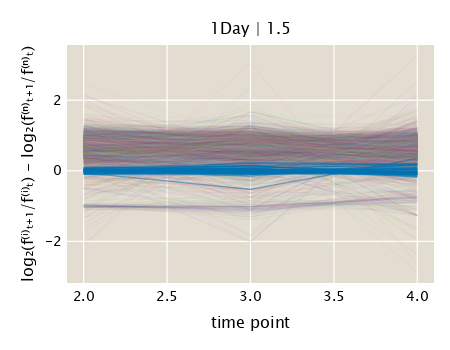

In [5]:
Random.seed!(42)

# Compute the mean population fitness s̄ₜ for all timepoints
data_st = DF.combine(
    DF.groupby(data_log[data_log.neutral, :], :time), :logf => DF.mean
)

# Locate index to extract the corresponding mean population fitness
idx_st = [findfirst(x .== data_st.time) for x in data_log.time]

# Add normalized column to dataframe
DF.insertcols!(
    data_log, :logf_norm => data_log.logf .- data_st[idx_st, :logf_mean]
)

# Initialize figure
fig = Figure(resolution=(450, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time point",
    ylabel="log₂(f⁽ⁱ⁾ₜ₊₁/f⁽ⁱ⁾ₜ) - log₂(f⁽ⁿ⁾ₜ₊₁/f⁽ⁿ⁾ₜ)",
    title="$(hub) | $(perturbation)"
)

# Define color palette
colors = ColorSchemes.glasbey_hv_n256

# group data by barcode
data_group = DF.groupby(data_log[.!data_log.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        bc.logf_norm,
        color=(colors[StatsBase.sample(1:length(colors))], 0.05)
    )
end # for

# group neutral barcodes by barcode
data_group = DF.groupby(data_log[data_log.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        bc.logf_norm,
        color=(ColorSchemes.seaborn_colorblind[1], 0.5)
    )
end # for

fig

We can see that, as expected, this normalization pulls the neutral lineages to
have a mean of zero, as expected. This subtracted quantity is the one we want to
apply our Bayesian inference over for this first stage of the model.

# Bayesian  model using `Turing.jl`

Our objective for this section will be to implement the Bayesian model using the
probabilistic programming language that `Turing.jl` encodes. For the first
iteration of the model, we will assume infinite resolution when determining the
barcode frequencies. In other words, although we do not directly measure the
frequencies, but rather a noisy readout via the number of reads, we will ignore
for now the uncertainty due to converting noisy reads to frequencies.

For this model, we will only use the $N$ neutral lineages. For these lineages,
we have that 
$$
f_{t+1}^{(n)} = f_{t}^{(n)} \mathrm{e}^{-\bar{s}_t T}.
$$
It is convenient to rewrite this equation as
$$
\frac{f_{t+1}^{(n)}}{f_{t}^{(n)}} = \mathrm{e}^{-\bar{s}_t T},
$$
where we can see that the ratio of frequencies depends exponentially on the mean
fitness we are trying to infer. Let us define 
$$
\gamma_t^{(n)} \equiv  \frac{f_{t+1}^{(n)}}{f_{t}^{(n)}}.
$$
Our dataset is then of the form
$$
\underline{\gamma}_t = (\gamma_t^{(1)}, \ldots, \gamma_t^{(N)}),
$$
i.e., the ratio of frequencies for all $N$ neutral lineages.

Writing Bayes' theorem we have
$$
\pi(\bar{s}_t \mid \underline{\gamma}_t) \propto
\pi(\underline{\gamma}_t \mid \bar{s}_t ) \pi
$$

Let's define the model using the @model macro from `Turing.jl`

In [177]:
Turing.@model function mean_fitness_neutrals(γ̲ₜ, t, σₛ, σₑ)
    ## Prior
    # Prior on the mean fitness
    s̲ₜ ~ Turing.filldist(Turing.Normal(0.0, σₛ), length(t))
    # Prior on error 
    σ̲ₜ ~ Turing.filldist(
        Turing.truncated(Turing.Normal(0 .+ eps(), σₑ); lower=0.0 + eps()), 
        length(t)
    )
    
    ## Likelihood
    for i = 1:size(γ̲ₜ, 2)
        γ̲ₜ[:, i] ~ Turing.MvLogNormal(
            -s̲ₜ, LinearAlgebra.Diagonal(σ̲ₜ .^2 .+ eps())
        )
    end # for
end # @model function

mean_fitness_neutrals (generic function with 2 methods)

Let's now extract the data.

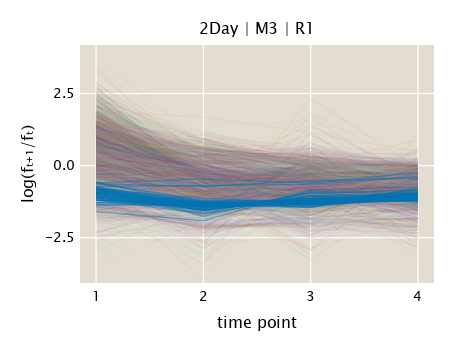

In [178]:
Random.seed!(42)

# Define information for data to extract
batch = "Batch4"
hub = "2Day"
perturbation = "M3"
rep = "R1"

# Extract data. 
data = df[
        (df.hub .== hub) .& 
        (df.batch .== batch) .&
        (df.perturbation .== perturbation) .&
        (df.rep .== rep)
    ,
:]

# Extract total counts per barcode
data_total = DF.combine(DF.groupby(data, :time), :count => sum)
# Extract total counts per barcode
data_total = DF.combine(DF.groupby(data, :time), :count => sum)
# Add total count column to dataframe
DF.leftjoin!(data, data_total; on=:time)
# Add frequency column
DF.insertcols!(data, :freq => data.count ./ data.count_sum)

# Initialize dataframe to save the freq changes
data_gamma = DF.DataFrame()

# Group data by barcode
data_group = DF.groupby(data, :barcode)

# Loop through each group
for d in data_group
    # Sort data by timepoint
    DF.sort!(d, :time)
    # Compute log change
    DF.append!(
        data_gamma, 
        DF.DataFrame(
            :barcode .=> first(d.barcode),
            :time => d.time[2:end],
            :γ => d.freq[2:end] ./ d.freq[1:end-1],
            :neutral .=> first(d.neutral)
        )
    )
end # for

# Extract data
γ = hcat(
    [
        DF.sort(d, :time).γ
        for d in DF.groupby(data_gamma[data_gamma.neutral, :], :barcode)
    ]...
)

# Initialize figure
fig = Figure(resolution=(450, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time point",
    ylabel="log(fₜ₊₁/fₜ)",
    title="$(hub) | $(perturbation) | $(rep)"
)

# Define color palette
colors = ColorSchemes.glasbey_hv_n256

# group data by barcode
data_group = DF.groupby(data_gamma[.!data_gamma.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        log.(bc.γ),
        color=(colors[StatsBase.sample(1:length(colors))], 0.05)
    )
end # for

# group neutral barcodes by barcode
data_group = DF.groupby(data_gamma[data_gamma.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        log.(bc.γ),
        color=(ColorSchemes.seaborn_colorblind[1], 0.5)
    )
end # for

fig

Now, we are ready to test the model.

In [179]:
Random.seed!(42)

# Define model
model = mean_fitness_neutrals(γ, unique(data_gamma.time), 5.0, 1.0)

# Sample
# # Suppress warning outputs
# Suppressor.@suppress begin
#     # Sample
chain = Turing.sample(
    model, 
    Turing.NUTS(0.65), 
    Turing.MCMCThreads(), 
    4_000, 
    4, 
    progress=false
)
# end

# Print summary stats
Turing.summarystats(chain)

┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/Suzsv/src/inference/hmc.jl:190
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/Suzsv/src/inference/hmc.jl:190
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/Suzsv/src/inference/hmc.jl:190
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/Suzsv/src/inference/hmc.jl:190


Summary Statistics
  parameters      mean       std      mcse     ess_bulk     ess_tail      rhat ⋯
      Symbol   Float64   Float64   Float64      Float64      Float64   Float64 ⋯

       s̲ₜ[1]    0.9777    0.0285    0.0002   18846.5731   11804.9180    1.0007 ⋯
       s̲ₜ[2]    1.3668    0.0310    0.0002   16273.4032   11261.6118    1.0000 ⋯
       s̲ₜ[3]    1.1941    0.0272    0.0002   17457.1423   12030.1005    1.0003 ⋯
       s̲ₜ[4]    1.0166    0.0275    0.0002   16587.3918   11515.2901    1.0003 ⋯
       σ̲ₜ[1]    0.2110    0.0207    0.0002   18079.5775   11824.4358    1.0000 ⋯
       σ̲ₜ[2]    0.2316    0.0226    0.0002   16527.7269   10932.9864    1.0002 ⋯
       σ̲ₜ[3]    0.2002    0.0199    0.0002   16971.6073   12039.5821    0.9999 ⋯
       σ̲ₜ[4]    0.2063    0.0204    0.0002   18616.4059   11955.0552    1.0002 ⋯
                                                                1 column omitted


Let's look at the traces for each of the walkers on each parameter.

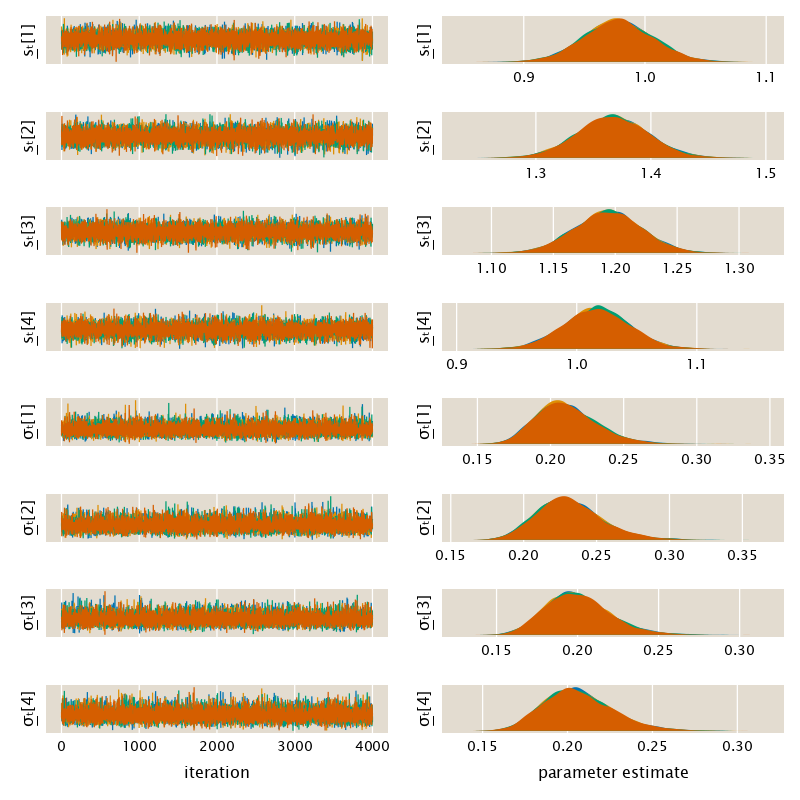

In [180]:
# Extract parameters
params = names(chain, :parameters)

# Extract number of chains
n_chains = length(MCMCChains.chains(chain))
# Extract number of parameters
n_samples = length(chain)

# Initialize figure
fig = Figure(resolution=(800, 800))

BayesFitness.viz.mcmc_trace_density!(fig, chain)

fig

These seem like perfectly reasonable parameter estimates.

Let's try another dataset.

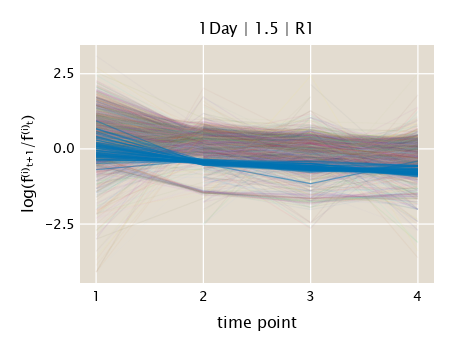

In [10]:
Random.seed!(42)

# Define information for data to extract
# Define batch
batch = "Batch2"
hub = "1Day"
perturbation = "1.5"
rep = "R1"

# Extract data. 
data = df[
        (df.hub .== hub) .& 
        (df.batch .== batch) .&
        (df.perturbation .== perturbation) .&
        (df.rep .== rep)
    ,
:]

# Extract total counts per barcode
data_total = DF.combine(DF.groupby(data, :time), :count => sum)
# Extract total counts per barcode
data_total = DF.combine(DF.groupby(data, :time), :count => sum)
# Add total count column to dataframe
DF.leftjoin!(data, data_total; on=:time)
# Add frequency column
DF.insertcols!(data, :freq => data.count ./ data.count_sum)

# Initialize dataframe to save the freq changes
data_gamma = DF.DataFrame()

# Group data by barcode
data_group = DF.groupby(data, :barcode)

# Loop through each group
for d in data_group
    # Sort data by timepoint
    DF.sort!(d, :time)
    # Compute log change
    DF.append!(
        data_gamma, 
        DF.DataFrame(
            :barcode .=> first(d.barcode),
            :time => d.time[2:end],
            :γ => d.freq[2:end] ./ d.freq[1:end-1],
            :neutral .=> first(d.neutral)
        )
    )
end # for

# Extract data
γ = hcat(
    [
        DF.sort(d, :time).γ
        for d in DF.groupby(data_gamma[data_gamma.neutral, :], :barcode)
    ]...
)

# Initialize figure
fig = Figure(resolution=(450, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time point",
    ylabel="log(f⁽ⁱ⁾ₜ₊₁/f⁽ⁱ⁾ₜ)",
    title="$(hub) | $(perturbation) | $(rep)"
)

# Define color palette
colors = ColorSchemes.glasbey_hv_n256

# group data by barcode
data_group = DF.groupby(data_gamma[.!data_gamma.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        log.(bc.γ),
        color=(colors[StatsBase.sample(1:length(colors))], 0.05)
    )
end # for

# group neutral barcodes by barcode
data_group = DF.groupby(data_gamma[data_gamma.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        log.(bc.γ),
        color=(ColorSchemes.seaborn_colorblind[1], 0.5)
    )
end # for

fig

This particular dataset has an issue that halts the sampler from getting
anywhere. The problem can be easily seen here:

In [11]:
maximum(γ)

Inf

There are infinities in the data. This must be because for some of the samples,
there were zero counts found in the set.

The easiest way to deal with this is to ignore data points that present this
issue. As structured right now, our algorithm cannot do that because of the
"inconvenient" use of the `MvLogNormal` that we use for the likelihood to speed
up the computation. In reality, this multivariate log normal has a diagonal
covariance matrix because all the variables we are trying to fit are independent
from each other.

But, we can instead loop through each of the entries, check if they are not
infinities, and then sample a single `LogNormal` distribution. Let's write this
version of the model.

In [15]:
Turing.@model function mean_fitness_neutrals_filt(γ̲ₜ, t, σₛ, σₑ)
    # Define parameter types
    s̲ₜ = Float64[]
    σ̲ₜ = Float64[]

    ## Prior
    # Prior on the mean fitness
    s̲ₜ ~ Turing.filldist(Turing.Normal(0.0, σₛ), length(t))
    # Prior on error 
    σ̲ₜ ~ Turing.filldist(
        Turing.truncated(Turing.Normal(0.0, σₑ); lower=0.0 + eps()), 
        length(t)
    )
    
    ## Likelihood
    
    for j = 1:size(γ̲ₜ, 2)
        # Define non-infinity indexes
        idx = (.!isinf.(γ̲ₜ[:, j])) .& (.!iszero.(γ̲ₜ[:, j]))
        # Sample
        γ̲ₜ[idx, j] ~ Turing.MvLogNormal(
            -s̲ₜ[idx], LinearAlgebra.Diagonal(σ̲ₜ[idx] .^2)
        )
    end # for
end # @model function

mean_fitness_neutrals_filt (generic function with 2 methods)

Now, let's sample

In [16]:
Random.seed!(42)

# Define model
model = mean_fitness_neutrals_filt(γ, unique(data_log.time), 5.0, 1.0)

# Sample
chain = Turing.sample(
    model, 
    Turing.NUTS(0.65), 
    Turing.MCMCThreads(), 
    4_000, 
    4, 
    progress=false
)
# end

# Print summary stats
Turing.summarystats(chain)

┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/Suzsv/src/inference/hmc.jl:190
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/Suzsv/src/inference/hmc.jl:190
┌ Info: Found initial step size
│   ϵ = 0.01435394287109375
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/Suzsv/src/inference/hmc.jl:190
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/Suzsv/src/inference/hmc.jl:190


Summary Statistics
  parameters      mean       std      mcse     ess_bulk     ess_tail      rhat ⋯
      Symbol   Float64   Float64   Float64      Float64      Float64   Float64 ⋯

       s̲ₜ[1]   -0.0044    0.0431    0.0003   18608.7911   12868.9170    1.0001 ⋯
       s̲ₜ[2]    0.4443    0.0064    0.0000   22176.0749   12484.1336    1.0003 ⋯
       s̲ₜ[3]    0.6308    0.0147    0.0001   20207.0833   12040.0490    1.0002 ⋯
       s̲ₜ[4]    0.7494    0.0154    0.0001   19896.6739   11882.9785    1.0001 ⋯
       σ̲ₜ[1]    0.3225    0.0315    0.0002   17400.3298   12635.6982    1.0001 ⋯
       σ̲ₜ[2]    0.0478    0.0047    0.0000   16738.2317   12085.2341    1.0002 ⋯
       σ̲ₜ[3]    0.1092    0.0108    0.0001   18325.7100   12367.2110    1.0008 ⋯
       σ̲ₜ[4]    0.1143    0.0112    0.0001   16951.0989   12379.4720    1.0000 ⋯
                                                                1 column omitted


This worked really well, avoiding the infinities. Let's look at the traces.

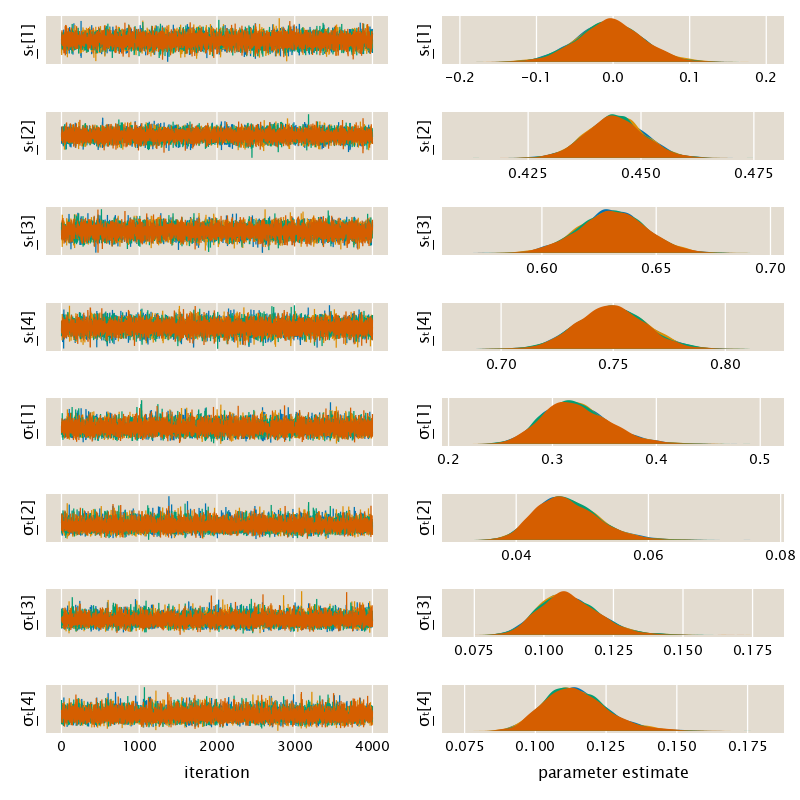

In [17]:
# Extract parameters
params = names(chain, :parameters)

# Extract number of chains
n_chains = length(MCMCChains.chains(chain))
# Extract number of parameters
n_samples = length(chain)

# Initialize figure
fig = Figure(resolution=(800, 800))

BayesFitness.viz.mcmc_trace_density!(fig, chain)

fig

These traces look good, and the estimates of the mean fitness also gave
reasonable values.

# Bayesian model with frequency inference uncertainty

So far our inference assumed that we measured barcode frequencies with infinite
precision. In reality, we measure noisy read counts and from that we must
estimate the relative frequency of each of the barcodes. For this part of the
inference, we 

In [182]:
Random.rand(Distributions.Dirichlet(α)) ./ Random.rand(Distributions.Dirichlet(α))

57-element Vector{Float64}:
  0.8059892559961277
  1.9579348399991519
  0.6852481487170805
  2.0205490304726923
  4.053084486815907
  0.17554335142135813
  1.2400055243580463
  0.2571554014158519
  1.4634645618311697
  5.7239294137006915
  ⋮
  3.126421053133404
  0.0803147132248942
  0.6292696112255602
 14.399196356733627
  4.622043797404956
  0.14008884321094528
  0.8230967937528204
  0.580223049006695
  1.0004742810233338

In [199]:
Turing.@model function mean_fitness_neutrals_full(
    r̲ₜ, r̲ₜ₊₁, α̲, σₛ, σₑ
)
    # Prior on mean fitness sₜ
    sₜ ~ Turing.Normal(0.0, σₛ)
    # Prior on LogNormal error σₜ
    σₜ ~ Turing.truncated(Turing.Normal(0.0, σₑ); lower=0.0)

    # Frequency distribution from Multinomial-Dirichlet model
    f̲ₜ ~ Turing.Dirichlet(α̲ .+ r̲ₜ)
    f̲ₜ₊₁ ~ Turing.Dirichlet(α̲ .+ r̲ₜ₊₁)

    # Check that all distributions are greater than zero. Although the counts
    # could be zero, we assume that the real frequencies are non-zero always.
    if any(iszero.(f̲ₜ)) | any(iszero.(f̲ₜ₊₁))
        Turing.@addlogprob! -Inf
        return 
    end

    # Compute frequency ratio
    γₜ = (f̲ₜ₊₁ ./ f̲ₜ)[1:end-1]

    # Sample posterior for frequency ratio. NOTE: This took me an incredibly
    # long time to figure out. Since the quantity γₜ is not given as input
    # observations to the model, Turing does not add the evaluation of the log
    # likelihood to the overall posterior. This ends up having sₜ sampled
    # directly from the prior. To force Turing to consider γₜ as an "observed"
    # variable, we must force the addition of the log density using the
    # @addlogprob! macro.
    Turing.@addlogprob! Turing.logpdf(
        Turing.MvLogNormal(
            FillArrays.Fill(-sₜ, length(γₜ)), 
            LinearAlgebra.I(length(γₜ)) .* σₜ^2
        ),
        γₜ
    )
end # @model function

mean_fitness_neutrals_full (generic function with 4 methods)

In [208]:
Random.seed!(42)

# Define information for data to extract
batch = "Batch2"
hub = "1Day"
perturbation = "1.5"
rep = "R1"

# Define time points
t1 = "T3"
t2 = "T4"
# Extract data. Note: The time T0 is common to all perturbations, thus, it must
# be extracted separately as a second condition.
data = df[
        (df.hub .== hub) .& 
        (df.batch .== batch) .&
        (df.perturbation .== perturbation) .&
        (df.rep .== rep) .&
        ((df.timepoint .== t1) .| (df.timepoint .== t2))
    ,
:]

# Group data by neutral barcode
data_group = DF.groupby(data[data.neutral, :], :barcode)

# Initialize array to save counts
r = Matrix{Int64}(undef, length(data_group) + 1, 2)
# Initialize array to save frequencies
f = Matrix{Float64}(undef, length(data_group) + 1, 2)

# Loop through barcodes
for (i, group) in enumerate(data_group)
    # Sort data by timepoint
    DF.sort!(group, :timepoint)
    r[i, :] = group.count
end # for

# Add mutant counts
r[end, 1] = sum(data[.!(data.neutral) .& (data.timepoint .== t1), :count])
r[end, 2] = sum(data[.!(data.neutral) .& (data.timepoint .== t2), :count])

# Set α values for Dirichlet distribution
α = ones(size(r, 1))
# Modify last α value for all mutant phenotypes
α[end] = sum(.!(data.neutral) .& (data.timepoint .== t1))

4971

In [209]:
Random.seed!(42)

# Define model
model = mean_fitness_neutrals_full(r[:, 1], r[:, 2], α, 5.0, 1.0)

# Sample
# # Suppress warning outputs
# Suppressor.@suppress begin
#     # Sample
chain = Turing.sample(
    model, 
    Turing.NUTS(1000, 0.65), 
    # Turing.MCMCThreads(), 
    1000, 
    # 6, 
    progress=false
)
# end

# Print summary stats
Turing.summarystats(chain)